In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Capstone/

Mounted at /content/gdrive


# Dataset Development
**Purpose:** To take curated dataset and bring into a form which will make training different types of modeling easier. Text preprocessing on the dataset will happen in the modeling notebooks themselves since this will be specific to the type of model we are using. 

In [ ]:
# uncomment when running in colab and restart runtime afterwards
# !pip install texthero

In [ ]:
# data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing libraries
import re
from datetime import datetime
import spacy
import nltk
from nltk import word_tokenize, sent_tokenize
# import texthero as hero
# from texthero import preprocessing
from sklearn.model_selection import train_test_split

# other
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

tqdm.pandas()
tqdm_notebook().pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def get_stats(column, quantiles = [0.025, 0.5, 0.975], log = True):
  '''
  Displays quantile outliers, histogram and a description of the data.  
  column: pd.Series object of column
  '''
  display(column.quantile(quantiles),
          column.hist(bins = 50, log = log),
          column.describe())

In [ ]:
# Load the control and experimental group
target_0 = pd.read_csv('data/target_0.csv')
target_1 = pd.read_csv('data/target_1.csv')

# adding target labels 
target_0['target'] = 0
target_1['target'] = 1

In [ ]:
total_df = target_0.append(target_1)

In [ ]:
# convert date to datetime format
total_df['date'] = pd.to_datetime(total_df['date'], infer_datetime_format=True)

In [ ]:
total_df.head(3)

,username,type,subreddit,date,text,ups,downs,num_response,target,first_sw_post
0,BIGBOIBICH,0,depression,2021-04-01 09:16:14,Honestly people don’t know about the fact that...,16,0,0,0,NaN
1,BIGBOIBICH,0,depression,2021-03-31 21:46:48,Ye I’ll try to today thank you for the tip,1,0,0,0,NaN
2,BIGBOIBICH,0,depression,2021-03-31 20:43:14,I’m sorry to hear that I really am but I hope ...,1,0,0,0,NaN


In [ ]:
#dropping potential duplicates
before = total_df.shape[0]
print(before)

total_df.drop_duplicates(inplace=True)

after = total_df.shape[0]
print("Percentages of rows dropped: ")
print(((before-after)/(before))*100)

4650897
Percentages of rows dropped: 
0.005138793656363493


In [ ]:
#dropping null values
before = total_df.shape[0]
print(before)

total_df = total_df[~total_df.text.isnull()]
total_df = total_df[~total_df.date.isnull()]

after = total_df.shape[0]
print("Percentage of rows dropped: ")
print(((before-after)/(before))*100)

4650658
Percentage of rows dropped: 
0.0006020653421515837


In [ ]:
#dropping posts that have [removed] in them
before = total_df.shape[0]
print(before)

total_df = total_df[~(total_df['text']=='[removed]')]

after = total_df.shape[0]
print("Percentage of rows dropped: ")
print(((before-after)/(before))*100)

4650630
Percentage of rows dropped: 
0.0013116502495360844


4. text preprocessing:
    
    - [x] removing `\n` and `\t` 
    - [x] removing digits
    - [x] removing urls
    - [x] removing HTML tags
    - [x] removing username mentions and subreddit mentions
    - [x] removing emojis
    - [x] removing SOME special characters - Retaining special characters that Transformer models could use.

5. remove comments and posts with too few words.


In [ ]:
def remove_newline_tab(text):
  new_text = re.sub('\n|\t', '', text)
  return new_text

def remove_mentions(text):
  new_text = re.sub('((\/*r\/)\w+)|((\/*u\/)\w+)','', text)
  return new_text

def remove_emojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  new_text = emoji_pattern.sub(r'', text)
  return new_text

def remove_some_special(text):
  specials_to_sub = "(\#|\$|\%|\^|\&|\*|\(|\)|\[|\]|\{|\}|\:|\/|\<|\>|\\|\||\`|\~|\-|\=|\_|\+|\"|\'|\||\\\\)"
  new_text = re.sub(specials_to_sub,'', text)
  return new_text

custom_pipeline = [preprocessing.remove_digits,
                   preprocessing.remove_urls,
                   preprocessing.remove_html_tags,
                   preprocessing.remove_whitespace]

In [ ]:
total_df['text'] = total_df['text'].progress_apply(remove_newline_tab).progress_apply(remove_emojis).progress_apply(remove_mentions)

total_df['text'] = hero.clean(total_df['text'], custom_pipeline)

total_df['text'] = total_df['text'].apply(remove_some_special)

total_df['text'] = hero.remove_whitespace(total_df['text'])

In [ ]:
# get word count of text in dataframe
total_df['word_count'] = total_df['text'].str.split().map(len)

In [ ]:
# get sentence count of text in dataframe
total_df['sent_count'] = total_df['text'].map(lambda x: len(sent_tokenize(x)))

0.025      1.0
0.500     15.0
0.975    206.0
Name: word_count, dtype: float64

count    4.650569e+06
mean     3.654456e+01
std      8.023457e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.500000e+01
75%      3.700000e+01
max      7.264000e+03
Name: word_count, dtype: float64

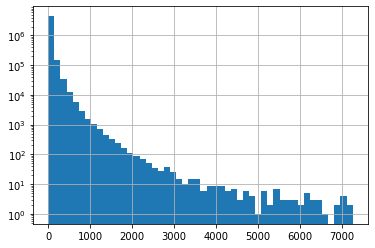

In [ ]:
get_stats(total_df.word_count)

In [ ]:
#dropping posts that have [removed] in them
before = total_df.shape[0]
print(before)

total_df = total_df[total_df['word_count']>=5]

after = total_df.shape[0]
print("Percentage of rows dropped: ")
print(((before-after)/(before))*100)

4650569
Percentage of rows dropped: 
17.38376529839682


6. Activity based filtering

In [ ]:
last_activity = total_df.sort_values('date').groupby('username').tail(1)
last_activity = last_activity[['username','date']]
last_activity.columns = ['username','last_active_date']

first_activity = total_df.sort_values('date').groupby('username').head(1)
first_activity = first_activity[['username','date']]
first_activity.columns = ['username','first_active_date']

activity_dates = pd.merge(last_activity, first_activity, on = 'username')
activity_dates.head()

,username,last_active_date,first_active_date
0,fuzzybeard,2012-03-19 22:22:54,2010-10-01 18:41:47
1,ilessthanthreemath,2012-10-24 23:41:23,2010-02-22 02:34:17
2,Igiveoutupvotes,2013-01-27 00:44:32,2011-12-29 21:47:43
3,1bravo69,2013-03-01 07:20:25,2012-02-28 02:39:48
4,veemonster,2013-05-04 11:11:13,2011-02-22 21:38:52


In [ ]:
total_df = total_df.merge(activity_dates, on = 'username')

In [ ]:
# days till last post
total_df['dtl'] = (total_df['last_active_date']-total_df['date']).astype('timedelta64[D]')

0.025       5.0
0.500     306.0
0.975    2102.0
Name: dtl, dtype: float64

count    3.842125e+06
mean     4.869540e+02
std      5.442702e+02
min      0.000000e+00
25%      1.120000e+02
50%      3.060000e+02
75%      6.710000e+02
max      4.787000e+03
Name: dtl, dtype: float64

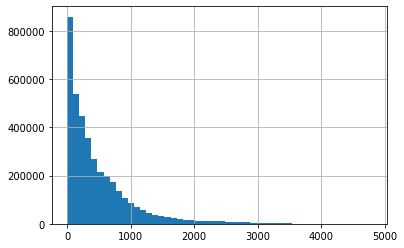

In [ ]:
get_stats(total_df.dtl, log = False)

From here is seems that 75% of the data is under 668 days which is about 2 years of posts. 

I think I should also delete posts that are too short so that data has actual material to look at.

I will be filtering out posts that:
1. Are more than two years from last post
2. Are too short? (this needs to be defined - will look into the description of how many words per comment/post. Obviously small comments that don't mean anything are useless. 

I think it also may be worth considering removing comments completely from the dataset and limiting it to only posts. 

In [ ]:
# removing posts that were more than two years old
before = total_df.shape[0]
print(before)

total_df = total_df[total_df['dtl']<=365*2]

after = total_df.shape[0]
print(after)
print("Percentage of posts dropped: ")
print(((before-after)/before)*100)

3842125
2994770
Percentage of posts dropped: 
22.05433191267853


7. Removing users with too little activity

In [ ]:
user_activity_counts = total_df.groupby('username').count().subreddit.reset_index().rename({'subreddit':'num_activity'}, axis = 1)
user_post_counts = total_df[total_df['type']==1].groupby('username').count().subreddit.reset_index().rename({'subreddit':'num_posts'}, axis = 1)
user_comm_counts = total_df[total_df['type']==0].groupby('username').count().subreddit.reset_index().rename({'subreddit':'num_comm'}, axis = 1)

0.025      1.0
0.500     20.0
0.975    281.0
Name: num_posts, dtype: float64

count    10626.000000
mean        47.241013
std         82.153868
min          1.000000
25%          8.000000
50%         20.000000
75%         49.000000
max        971.000000
Name: num_posts, dtype: float64

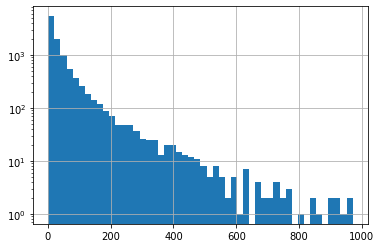

In [ ]:
get_stats(user_post_counts.num_posts)

0.025      4.0
0.500    136.0
0.975    898.0
Name: num_comm, dtype: float64

count    10203.000000
mean       244.319024
std        263.419058
min          1.000000
25%         41.000000
50%        136.000000
75%        361.500000
max        997.000000
Name: num_comm, dtype: float64

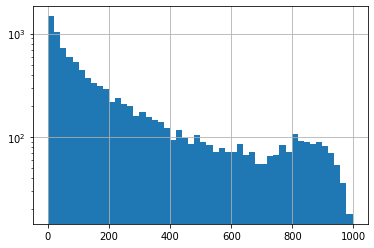

In [ ]:
get_stats(user_comm_counts.num_comm)

0.025       6.00
0.050      11.00
0.500     157.00
0.950     950.50
0.975    1038.75
Name: num_activity, dtype: float64

count    10651.000000
mean       281.172660
std        305.647712
min          1.000000
25%         52.000000
50%        157.000000
75%        404.500000
max       1829.000000
Name: num_activity, dtype: float64

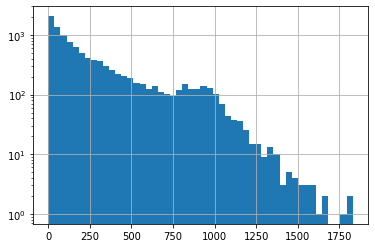

In [ ]:
get_stats(user_activity_counts.num_activity, quantiles=[0.025, 0.05, 0.5, 0.95, 0.975])

In [ ]:
# removing users with less than 11 activity items
total_df = total_df.merge(user_activity_counts, on = 'username')

In [ ]:
# should be dropping 5% of users
before = total_df.shape[0]
print(before)

total_df = total_df[total_df['num_activity']>11]

after = total_df.shape[0]
print(after)
print("Percentage of posts dropped: ")
print(((before-after)/before)*100)

2994770
2990817
Percentage of posts dropped: 
0.1319967810549725


In [ ]:
total_df.head()

,username,type,subreddit,date,text,ups,downs,num_response,target,first_sw_post,word_count,sent_count,last_active_date,first_active_date,dtl,num_activity
0,BIGBOIBICH,0,depression,2021-04-01 09:16:14,Honestly people don’t know about the fact that...,16,0,0,0,NaN,62,2,2021-04-02 14:23:52,2019-01-24 08:01:01,1.0,138
1,BIGBOIBICH,0,depression,2021-03-31 21:46:48,Ye I’ll try to today thank you for the tip,1,0,0,0,NaN,10,1,2021-04-02 14:23:52,2019-01-24 08:01:01,1.0,138
2,BIGBOIBICH,0,depression,2021-03-31 20:43:14,I’m sorry to hear that I really am but I hope ...,1,0,0,0,NaN,14,1,2021-04-02 14:23:52,2019-01-24 08:01:01,1.0,138
3,BIGBOIBICH,0,depression,2021-03-31 16:18:40,It really does feel like that,1,0,0,0,NaN,6,1,2021-04-02 14:23:52,2019-01-24 08:01:01,1.0,138
4,BIGBOIBICH,0,depression,2021-03-31 16:18:17,Thank you I really mean that and hope you have...,2,0,0,0,NaN,13,1,2021-04-02 14:23:52,2019-01-24 08:01:01,1.0,138


In [ ]:
before = total_df.shape[0]
print(before)

total_df = total_df[~((total_df['subreddit']=='SuicideWatch')&(total_df['type']==1))]

after = total_df.shape[0]
print(after)
print("Percentage of posts dropped: ")
print(((before-after)/before)*100)

2990817
2985801
Percentage of posts dropped: 
0.16771337062749075


In [ ]:
total_df.to_csv('data/total_df.csv', index = False)

In [ ]:
#total_df = pd.read_csv('data/total_df.csv', low_memory=False)

In [ ]:
user_df = total_df.groupby('username').agg(['mean','count'])['target'].reset_index().rename({'mean':'target'}, axis = 1)
user_df = user_df[~user_df['target'].isna()]
user_df['target'] = user_df['target'].astype('int')

In [ ]:
user_df.head()

,username,target,count
0,---AmoEboid---,0,83
1,--Doc_Holliday,0,209
2,--NoIdeaWhatImDoing,0,16
3,--Solus,1,263
4,-AnxiousWallflower-,1,106


In [ ]:
display(user_df.shape, user_df.dtypes, user_df.groupby('target').username.nunique())

(10056, 3)

username    object
target       int64
count        int64
dtype: object

target
0    4981
1    5075
Name: username, dtype: int64

In [ ]:
user_df.to_csv('data/user_df.csv', index=False)
X, y = user_df.drop('target', axis = 1), user_df.target

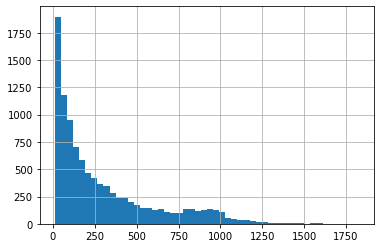

In [ ]:
user_df['count'].hist(bins = 50)

In [ ]:
y.value_counts()

1    5075
0    4981
Name: target, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=10)

In [ ]:
display(X_train.shape, X_test.shape, X_val.shape)

(5631, 2)

(3017, 2)

(1408, 2)

In [ ]:
display(y_train.value_counts(), y_test.value_counts(), y_val.value_counts())

1    2847
0    2784
Name: target, dtype: int64

1    1515
0    1502
Name: target, dtype: int64

1    713
0    695
Name: target, dtype: int64

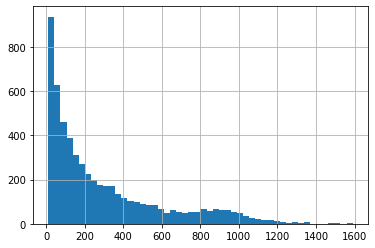

In [ ]:
X_train['count'].hist(bins = 50)

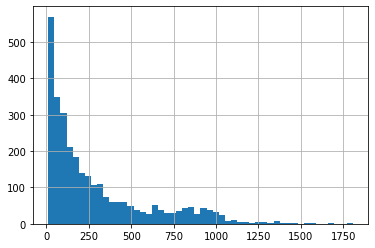

In [ ]:
X_test['count'].hist(bins = 50)

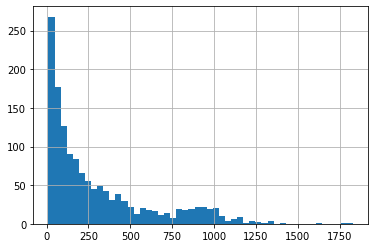

In [ ]:
X_val['count'].hist(bins = 50)

In [ ]:
X_train.to_csv('data/train_users.csv', index = False)
X_test.to_csv('data/test_users.csv', index = False)
X_val.to_csv('data/val_users.csv', index = False)

---
Aggregated on month-year combination

In [ ]:
total_df = pd.read_csv('data/total_df.csv', low_memory=False)
total_df['date'] = pd.to_datetime(total_df['date'], infer_datetime_format=True)
total_df['month_year'] = pd.to_datetime(total_df['date']).dt.to_period('M')
total_my = total_df.groupby(['username','month_year'], as_index=False).agg({'text': ' '.join, 'target': np.mean,\
                                                                            'subreddit': list, 'word_count': np.sum, 'sent_count':np.sum})

0.025       8.0
0.500     276.0
0.800    1059.0
0.900    2005.0
Name: word_count, dtype: float64

count    157677.000000
mean        814.829461
std        1925.083391
min           5.000000
25%          80.000000
50%         276.000000
75%         819.000000
max      261135.000000
Name: word_count, dtype: float64

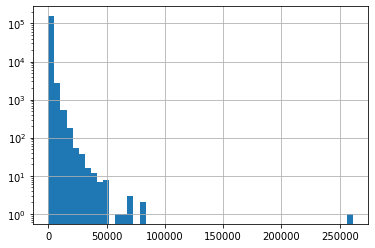

In [ ]:
get_stats(total_my.word_count, quantiles=[0.025, 0.5, 0.8, 0.9])

In [ ]:
total_my['target'] = total_my['target'].astype('int')
total_my.to_csv('data/total_my.csv', index = False)
total_my.to_pickle('data/total_my.pkl')

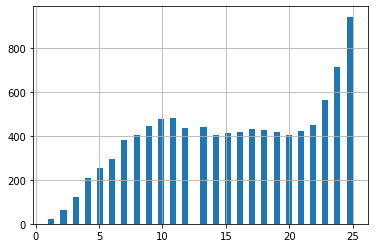

In [ ]:
my_sequence_counts = total_my.groupby(['target','username'], as_index= False ).text.count().rename({'text':'count'}, axis = 1)
my_sequence_counts['count'].hist(bins = 50)

Aggregated without considering time at all.

In [ ]:
timeless_df = total_df.groupby(['username'], as_index = False).agg({'text': ' '.join, 'target': np.mean})
timeless_df['target'] = timeless_df['target'].astype('int')
timeless_df.to_csv('data/timeless_total_df.csv', index = False)

In [ ]:
timeless_df.target.value_counts()

1    5075
0    4981
Name: target, dtype: int64

In [ ]:
user_targets = total_df.groupby('username').target.mean().reset_index()
user_targets = user_targets[~user_targets['target'].isnull()]
user_targets['target'] = user_targets['target'].astype('int')
user_targets.to_csv('data/user_targets.csv', index = False)